In [2]:
!pip install keras_preprocessing==1.0.6

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import os
import cv2
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from glob import glob
import glob
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Input, Dropout, ZeroPadding2D, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, AveragePooling2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


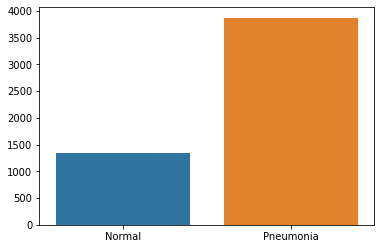

In [5]:
trainLabels = "/content/drive/MyDrive/chest_xray/train/"
testLabels = "/content/drive/MyDrive/chest_xray/test/"
valLabels = "/content/drive/MyDrive/chest_xray/val/"

trainNormal = glob.glob(trainLabels+"NORMAL/*.jpeg")
trainPneumonia = glob.glob(trainLabels+"PNEUMONIA/*.jpeg")
valNormal = glob.glob(valLabels+"NORMAL/*.jpeg")
valPneumonia = glob.glob(valLabels+"PNEUMONIA/*.jpeg")
testNormal = glob.glob(testLabels+"NORMAL/*.jpeg")
testPneumonia = glob.glob(testLabels+"PNEUMONIA/*.jpeg")

sns.barplot(x=["Normal","Pneumonia"],y=[len(trainNormal),len(trainPneumonia)])

In [6]:
print('Pneumonia x-ray images in training set = ', len(trainPneumonia))
print('Normal x-ray images in training set = ', len(trainNormal))
print('Pneumonia x-ray images in validation set = ', len(valPneumonia))
print('Normal x-ray images in validation set = ', len(valNormal))
print('Pneumonia x-ray images in test set = ', len(testPneumonia))
print('Normal x-ray images in test set = ', len(testNormal))

Pneumonia x-ray images in training set =  3875
Normal x-ray images in training set =  1341
Pneumonia x-ray images in validation set =  8
Normal x-ray images in validation set =  8
Pneumonia x-ray images in test set =  390
Normal x-ray images in test set =  234


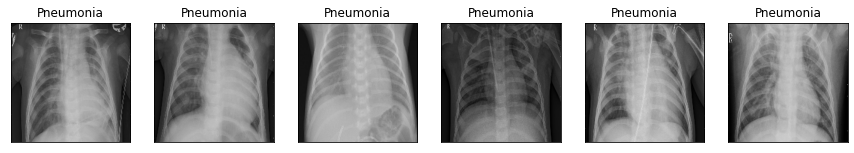

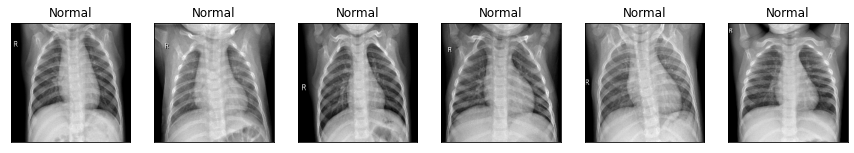

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainPneumonia[i])
    img = cv2.resize(img, (200,200))
    ax.imshow(img)
    ax.set_title("Pneumonia")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainNormal[i])
    img = cv2.resize(img, (200,200))
    ax.imshow(img)
    ax.set_title("Normal")
# fig.tight_layout()    
plt.show()

In [8]:
training = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
validation = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
testing = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

In [9]:
training_dataset = training.flow_from_directory(trainLabels,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')

validation_dataset = validation.flow_from_directory(valLabels,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')

testing_dataset = testing.flow_from_directory(testLabels,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
training_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
training_dataset.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [24]:
# from keras.applications.resnet50 import ResNet50
# callback = ReduceLROnPlateau(monitor='val_loss', patience = 2, cooldown=0, verbose=1, factor=0.6, min_lr=0.000001)
resmodel = tf.keras.applications.resnet50.ResNet50(weights = None, include_top=False, input_shape= (224,224,3), pooling = 'avg')
# for layers in resmodel.layers:
#     layers.trainable = True
last_layer=resmodel.get_layer('conv3_block3_1_relu')#conv2_block1_out
last_output = last_layer.output

# x = AveragePooling2D((2,2), padding = 'same')(last_output)

x=tf.keras.layers.Flatten()(last_output)
# # x=tf.keras.layers.Dense(1024,activation='relu')(x)
# x=tf.keras.layers.Dropout(0.2)(x)
# x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x) ####### BEST RESULTS WITH ONE 0.5 DROPOUT LAYER AND EVERYTHING ELSE THE SAME ###########
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

modelres=tf.keras.Model(resmodel.input,x)

modelres.compile(loss = 'binary_crossentropy', 
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), #0.0001 and no 256 dense layer led to low loss
             metrics = ['accuracy']) #lr of 0.00005 with dense layers led to good training but same val accuracy
modelres.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [25]:
callback1 = ReduceLROnPlateau(monitor='val_loss', patience = 3, cooldown=0, verbose=1, factor=0.5, min_lr=0.0000001)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = False)
history = modelres.fit(training_dataset, validation_data = validation_dataset, epochs = 60, callbacks = [callback1, callback2])

Epoch 1/60
163/163 [==============================] - 73s 434ms/step - loss: 0.2075 - accuracy: 0.9112 - val_loss: 1.4757 - val_accuracy: 0.5000 - lr: 5.0000e-05
Epoch 2/60
163/163 [==============================] - 73s 447ms/step - loss: 0.0794 - accuracy: 0.9697 - val_loss: 1.0162 - val_accuracy: 0.5625 - lr: 5.0000e-05
Epoch 3/60
163/163 [==============================] - 70s 431ms/step - loss: 0.0468 - accuracy: 0.9835 - val_loss: 0.2254 - val_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 4/60
163/163 [==============================] - 70s 429ms/step - loss: 0.0264 - accuracy: 0.9929 - val_loss: 0.3151 - val_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 5/60
163/163 [==============================] - 72s 439ms/step - loss: 0.0183 - accuracy: 0.9952 - val_loss: 0.0763 - val_accuracy: 1.0000 - lr: 5.0000e-05
Epoch 6/60
163/163 [==============================] - 72s 441ms/step - loss: 0.0123 - accuracy: 0.9979 - val_loss: 0.1397 - val_accuracy: 0.9375 - lr: 5.0000e-05
Epoch 7/60
163/163 [========

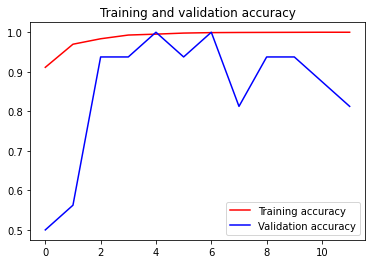

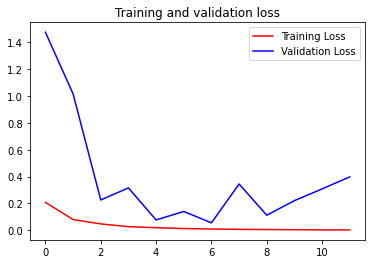

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']



loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
# norm_path = 'chest_xray/test/NORMAL'
# arr = os.listdir(norm_path)
# # print(arr)
# # random.shuffle(arr)
# for i in arr[:10]:
# #     print(i)
#     img = cv2.imread(norm_path+'/'+i)
#     img = cv2.resize(img, (224,224))
#     plt.imshow(img)
#     plt.show()
    
#     X = image.img_to_array(img)
#     X = np.expand_dims(X,axis = 0)
#     images = np.vstack([X])
    
#     val = modelres.predict(images)
#     print(val)
#     if val < 0.1:
#         print("Normal")
#     else:
#         print("Pneumonia")
        

In [16]:
modelres.evaluate(testing_dataset)

20/20 [==============================] - 190s 10s/step - loss: 1.3489 - accuracy: 0.7356


[1.348861813545227, 0.7355769276618958]

In [17]:
# norm_path2 = 'chest_xray/test/PNEUMONIA'
# arr = os.listdir(norm_path2)
# # print(arr)
# # random.shuffle(arr)
# for i in arr[:10]:
# #     print(i)
#     img = cv2.imread(norm_path2+'/'+i)
#     img = cv2.resize(img, (224,224))
#     plt.imshow(img)
#     plt.show()
    
#     X = image.img_to_array(img)
#     X = np.expand_dims(X,axis = 0)
#     images = np.vstack([X])
    
#     val2 = modelres.predict(images)
#     print(val2)
#     if val2 < 0.1:
#         print("Normal")
#     else:
#         print("Pneumonia")
        

In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50
# callback = ReduceLROnPlateau(monitor='val_loss', patience = 2, cooldown=0, verbose=1, factor=0.6, min_lr=0.000001)
resmodel = ResNet50(weights = 'imagenet',include_top=False, input_shape= (224,224,3))
for layers in resmodel.layers:
    layers.trainable = False
# print(resmodel.layers[18].name)
last_layer=resmodel.get_layer('conv3_block3_1_relu') #conv2_block1_out
last_output = last_layer.output

x=tf.keras.layers.Flatten()(last_output)
# x=tf.keras.layers.Dense(1024,activation='relu')(x)
# x=tf.keras.layers.Dropout(0.2)(x)
# x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

modelresimg=tf.keras.Model(resmodel.input,x)

modelresimg.compile(loss = 'binary_crossentropy', 
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #0.0001 and no 256 dense layer led to low loss
             metrics = ['accuracy']) #lr of 0.00005 with dense layers led to good training but same val accuracy
modelresimg.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [20]:
callback1 = ReduceLROnPlateau(monitor='val_loss', patience = 3, cooldown=0, verbose=1, factor=0.5, min_lr=0.0000001)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
historyimagenet = modelresimg.fit(training_dataset, validation_data = validation_dataset, epochs = 60, callbacks = [callback1, callback2])

Epoch 1/60
163/163 [==============================] - 65s 397ms/step - loss: 0.2324 - accuracy: 0.9316 - val_loss: 0.3909 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/60
163/163 [==============================] - 65s 396ms/step - loss: 0.0447 - accuracy: 0.9824 - val_loss: 0.1924 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/60
163/163 [==============================] - 65s 398ms/step - loss: 0.0324 - accuracy: 0.9872 - val_loss: 0.0559 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/60
163/163 [==============================] - 66s 403ms/step - loss: 0.0198 - accuracy: 0.9935 - val_loss: 0.0321 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/60
163/163 [==============================] - 65s 398ms/step - loss: 0.0315 - accuracy: 0.9885 - val_loss: 0.0090 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/60
163/163 [==============================] - 66s 407ms/step - loss: 0.0129 - accuracy: 0.9952 - val_loss: 0.0047 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/60
163/163 [==============================] 

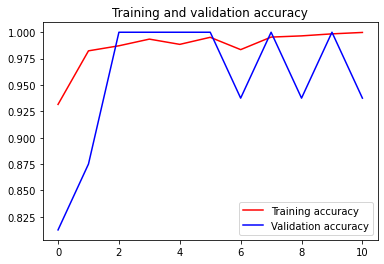

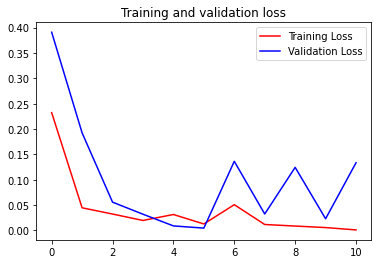

In [21]:
acc = historyimagenet.history['accuracy']
val_acc = historyimagenet.history['val_accuracy']



loss = historyimagenet.history['loss']
val_loss = historyimagenet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
# norm_path = 'chest_xray/test/NORMAL'
# arr = os.listdir(norm_path)
# # print(arr)
# # random.shuffle(arr)
# for i in arr[:10]:
# #     print(i)
#     img = cv2.imread(norm_path+'/'+i)
#     img = cv2.resize(img, (224,224))
#     plt.imshow(img)
#     plt.show()
    
#     X = image.img_to_array(img)
#     X = np.expand_dims(X,axis = 0)
#     images = np.vstack([X])
    
#     val = modelresimg.predict(images)
#     print(val)
# #     if val == 0:
# #         print("Normal")
# #     else:
#         print("Pneumonia")

In [23]:
modelresimg.evaluate(testing_dataset)

20/20 [==============================] - 7s 348ms/step - loss: 0.9864 - accuracy: 0.8045


[0.9863795638084412, 0.8044871687889099]